<a href="https://colab.research.google.com/github/OmdenaAI/marseille-chapter-stop-online-violence-nlp/blob/main/Copy_of_trying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing the necessary packages
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetB0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import keras
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import PIL
import sys
import urllib
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from matplotlib import pyplot as plt
from tensorflow.keras import layers
tf.__version__

'2.11.0'

In [2]:
mask_url = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/7bt2d592b9-1.zip'
urllib.request.urlretrieve(mask_url , filename = 'face_mask.zip')

('face_mask.zip', <http.client.HTTPMessage at 0x7f61088e7f10>)

In [3]:
import requests
import zipfile
from pathlib import Path
new_dir_path = '/content/data'
os.mkdir(new_dir_path)

data_path = Path("data/")
image_path = data_path / "facemask_zip"

os.mkdir(data_path / "face_mask")

In [4]:
with open(data_path / "face_mask.zip", "wb") as f:
  request = requests.get (mask_url)
  print("getting face_mask dataset")
  f.write(request.content)

with zipfile.ZipFile(data_path / "face_mask.zip", "r") as zip_ref:
  print("Unzipping face_mask data...")
  zip_ref.extractall(image_path)

getting face_mask dataset
Unzipping face_mask data...


In [5]:
with zipfile.ZipFile("/content/data/facemask_zip/Face Mask Dataset 2022/Face_Mask_Dataset.zip", "r") as zip_ref:
  print("Unzipping face_mask data...")
  zip_ref.extractall(data_path/"face_mask")

Unzipping face_mask data...


In [6]:
img_path = "/content/data/face_mask/Face_Mask_Dataset"

def walk_through_dir(dir_path):
  for dir_path, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dir_path}'.")

walk_through_dir(img_path)

there are 2 directories and 0 images in '/content/data/face_mask/Face_Mask_Dataset'.
there are 0 directories and 10107 images in '/content/data/face_mask/Face_Mask_Dataset/With_Mask'.
there are 0 directories and 10240 images in '/content/data/face_mask/Face_Mask_Dataset/Without_Mask'.


In [7]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/data/face_mask/Face_Mask_Dataset", 
                                                            shuffle = True,
                                                            image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                            batch_size=BATCH_SIZE
                                                            )

Found 20347 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
class_names

['With_Mask', 'Without_Mask']

In [10]:
len(dataset)

204

In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(100, 224, 224, 3)
[0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0
 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0]


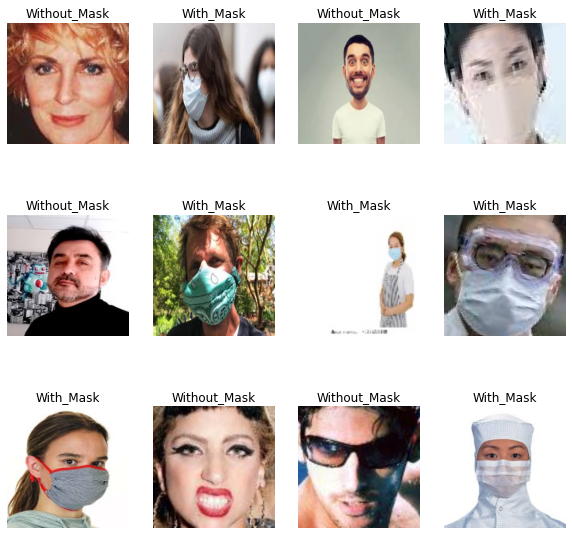

In [12]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

204

In [14]:
dataset = dataset.map(lambda x,y: (x/255,y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
def get_data_partitions(ds, train_split = 0.84, val_split = 0.15, test_split = 0.01, shuffle = True, shuffle_size = 100000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

#    train_ds = scale(train_ds) 
#    val_ds = scale(val_ds) 
#    test_ds = scale(test_ds)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_data_partitions(dataset)

In [17]:
len(train_ds)

171

In [18]:
len(test_ds)

3

In [ ]:
#for image_batch, labels_batch in train_ds:
#  print(image_batch.shape)
#  print(labels_batch.shape)
#  break

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
#resize_and_rescale = tf.keras.Sequential([
#    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
#    layers.experimental.preprocessing.Rescaling(1.0/255)
#])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
# patience=2

In [22]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)

In [23]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
inputs = keras.Input(shape=(224,224, 3))
x = data_augmentation(inputs) 
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 2)                 1154      
                                                                 
Total params: 940,274
Trainable params: 928,162
Non-trainable

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  229


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 2)                 1154      
                                                                 
Total params: 940,274
Trainable params: 814,690
Non-trainable

In [ ]:
model.evaluate(val_ds)

ValueError: ignored

In [ ]:
initial_epochs = 20
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
results = model.evaluate(test_set, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
import numpy as np
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = np.around(cm, decimals=2)
      cm[np.isnan(cm)] = 0.0
      print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in training_set.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [ ]:
 
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

es = EarlyStopping(patience=1, restore_best_weights=True)

history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_set,
                         callbacks= [es,checkpoint])


In [ ]:
model.evaluate(test_set)

In [ ]:
def compare_histories(original_history, new_history, initial_epochs):
    """
    Compares two model history objects.
    """
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(9, 9))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start of Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start of Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
compare_histories(r, history_fine, initial_epochs=10)

In [ ]:
preds = model.predict(test_set, verbose = 1)

In [ ]:
pred_labels = tf.argmax(preds, axis=1)
pred_labels[:10]

In [ ]:
category = os.listdir("/content/dataset/test")
category

In [ ]:
class_to_idx(category)

In [ ]:
def create_dataset(img_folder):
   
    test_x=[]
    test_label=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (224, 224),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            test_x.append(image)
            test_label.append(dir1)
    return test_x, test_label

In [ ]:
test_x, test_label = create_dataset("/content/dataset/test")

In [ ]:
test_labels = tf.argmax(test_label, axis=1)
test_labels[:10]